In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [1]:
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, Input, LSTM, Dropout, Activation,Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
import tensorflow
print(tensorflow.__version__)

2.18.0


# Data Exploration

In [6]:
train_data=pd.read_csv('./train.csv')
# test_data=pd.read_csv('/content/drive/MyDrive/com_tox_proj/test.csv')

In [7]:
train_data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28153,4a8ba0bcb97a7757,"""\n\nWiktionary has the plural as """"confettis""...",0,0,0,0,0,0
47203,7e166fd29fa452db,existent sourcing for controversial assertions...,0,0,0,0,0,0
97825,0b5478258c2c9e62,I saw agreement for the text's,0,0,0,0,0,0
78588,d24cc0e87c9c9871,"""\n\n What the Hell? Bill Oreilly Site \n\nAcc...",1,0,0,0,0,0
104011,2c7a5ad6bc830a58,Just now you reverted to a version which delet...,0,0,0,0,0,0


In [8]:
print('Train data shape:',train_data.shape)
# print('Test data shape:',test_data.shape)

Train data shape: (159571, 8)


In [9]:
print(train_data.iloc[random.randint(0,train_data.shape[0])]['comment_text'])

Look at my page sir.This user is attacking at me and deleting my comments.If you block me then it is your duty to also block him. 14.97.180.58


In [10]:
print("\nDataset Info:")
print(train_data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [11]:
# Check for missing values
print("\nMissing Values:")
print(train_data.isnull().sum())


Missing Values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64



Label Counts:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


<ipython-input-11-051360f7118a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


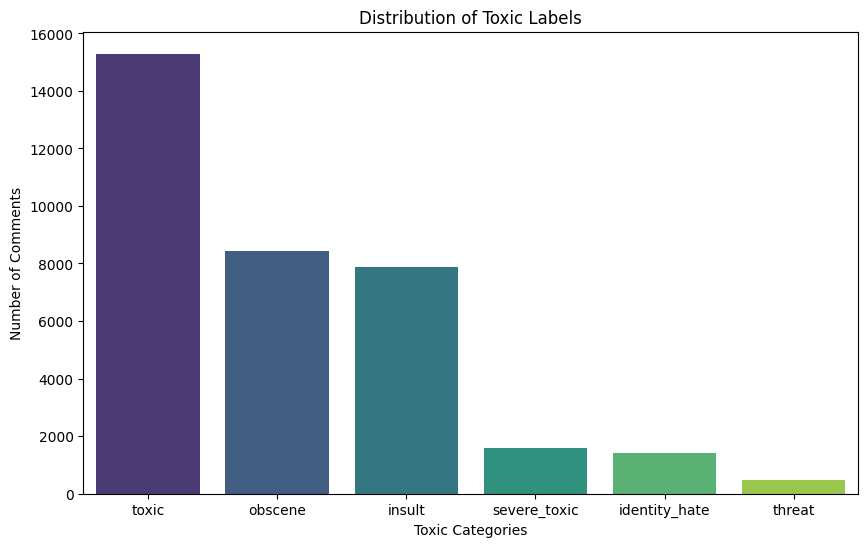

In [ ]:
Label_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

label_counts = train_data[Label_columns].sum().sort_values(ascending=False)
print("\nLabel Counts:")
print(label_counts)

plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Toxic Labels")
plt.xlabel("Toxic Categories")
plt.ylabel("Number of Comments")
plt.show()

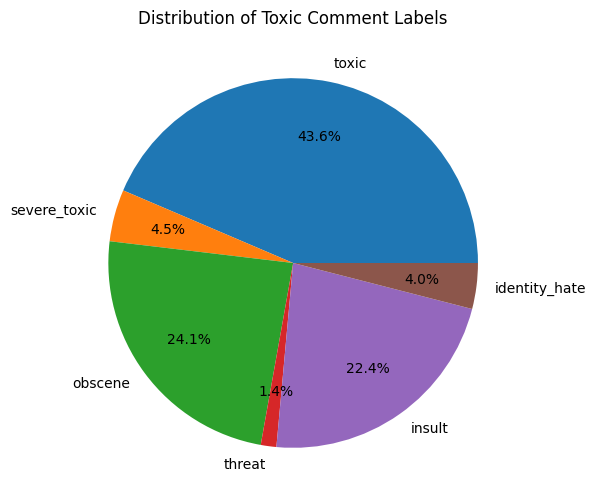

In [ ]:
per_dic = {}
# Count number of each category of comment
for x in train_data.columns[2:]:
    per_dic[x] = train_data[x].sum()

# Plot the pie chart
plt.figure(figsize=(7, 6),)
plt.pie(
    per_dic.values(),
    labels=per_dic.keys(),
    autopct='%1.1f%%',
    pctdistance=0.70
)
plt.title('Distribution of Toxic Comment Labels')
plt.show()

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(column_name,ax, width=720, height=520):

    if column_name not in train_data.columns[2:8]:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return

    text = ' '.join(train_data[train_data[column_name] == 1]['comment_text'])
    wordcloud_ = WordCloud(width=width, height=height, background_color='black').generate(text)

    # ax.figure(figsize=(6, 6))
    ax.imshow(wordcloud_, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {column_name} Comments')

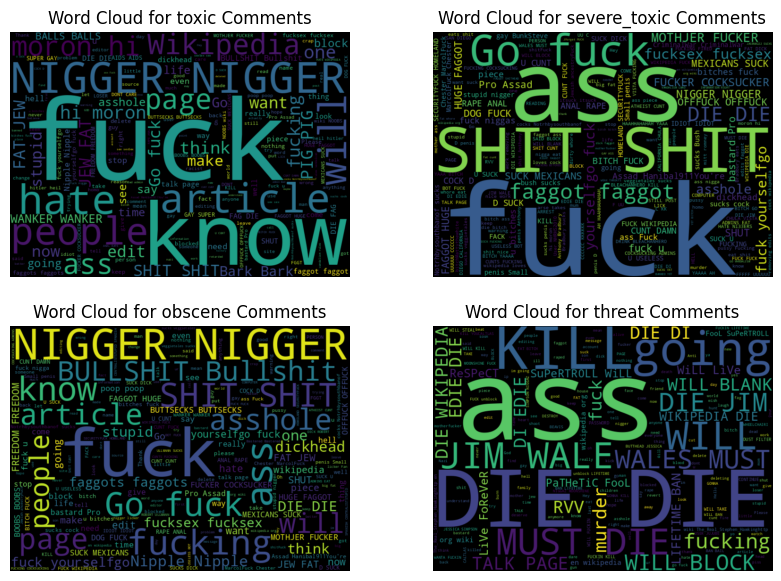

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,7))
plot_wordcloud('toxic',ax[0,0])
plot_wordcloud('severe_toxic',ax[0,1])
plot_wordcloud('obscene',ax[1,0])
plot_wordcloud('threat',ax[1,1])

# Text pre_processing

In [13]:
# Important libraries
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avina\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [14]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]','',text)
    text =  text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


In [15]:
train_data['comment_text'].apply(clean_text)

0         explanation edits made username hardcore metal...
1         daww matches background colour im seemingly st...
2         hey man im really trying edit war guy constant...
3         cant make real suggestions improvement wondere...
4                       sir hero chance remember page thats
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really dont think understand came idea bad rig...
Name: comment_text, Length: 159571, dtype: object

In [16]:
from tensorflow.keras.layers import TextVectorization

In [17]:
X = train_data['comment_text']
y = train_data[train_data.columns[2:]].values

In [18]:
y.shape

(159571, 6)

In [19]:
max_words = 200000
vectorizer = TextVectorization(max_tokens=max_words,
                               output_sequence_length=1800,
                               output_mode='int')

In [20]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [21]:
vectorized_text.shape

TensorShape([159571, 1800])

In [22]:
y.shape

(159571, 6)

In [23]:
dataset = tensorflow.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(vectorized_text.shape[0])
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [24]:
train = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

In [25]:
train.as_numpy_iterator().next()

(array([[  49,   49,   79, ...,    0,    0,    0],
        [3523,  679,  387, ...,    0,    0,    0],
        [1544,   14,   77, ...,    0,    0,    0],
        ...,
        [   8,   25,   11, ...,    0,    0,    0],
        [  70,  265, 4549, ...,    0,    0,    0],
        [   7,   20, 3826, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [26]:
inp = Input(shape=(1800,))
x = Embedding(max_words, 32)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1800, 100)      │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,438,556 (24.56 MB)

 Trainable params: 6,438,556 (24.56 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    print("GPU Device:", tf.test.gpu_device_name())
else:
    print("GPU is not available.")


GPU is not available.


In [30]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(vectorized_text,y,batch_size=128, epochs=2, validation_data=val)

Epoch 1/2
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 4288s 3s/step - accuracy: 0.8405 - loss: 0.1314 - val_accuracy: 0.9946 - val_loss: 0.0428
Epoch 2/2
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 3233s 3s/step - accuracy: 0.9748 - loss: 0.0454 - val_accuracy: 0.9941 - val_loss: 0.0389


In [35]:
model.save('my_model.keras')

In [36]:
model.save('my_model_h.h5')

In [38]:
model.save_weights('my_model.weights.h5')
